# 03 - Model Evaluation: Checkpoint Analysis

**Objective**: Load and analyze the trained Legal-Longformer checkpoint.

This notebook evaluates the model saved during training, examining:
- Overall metrics (F1, Precision, Recall)
- Per-class performance
- Confusion analysis
- Comparison with TF-IDF baseline

In [1]:
import sys
sys.path.insert(0, '..')

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from src.data_loader import DataLoader
from src.model_trainer import DataPreparer
from src.model_evaluator import MultiLabelEvaluator
from src.bert_trainer import (
    DeviceManager, 
    HybridLegalClassifier,
    LegalLongformerTrainer,
)

sns.set_style('whitegrid')
pd.set_option('display.max_colwidth', 50)

## 1. Load Data and Checkpoint

In [2]:
# Load data (same as training)
loader = DataLoader('../data/TRDataChallenge2023.txt')
preparer = DataPreparer(loader, min_label_count=50, random_state=42)
data = preparer.prepare(max_features=10000, ngram_range=(1, 2))

print(data.summary())
print(f"\nLabels: {len(data.label_names)}")

INFO:src.model_trainer:Filtered 3 documents with < 10 words


PREPARED DATA SUMMARY
Train samples:     11,706
Validation samples:2,509
Test samples:      2,509
Number of labels:  41
Feature dimension: 10000

Labels: 41


In [3]:
# Check available model files
import json

model_path = Path('../outputs/legal_longformer_best.pt')
history_path = Path('../outputs/legal_longformer_best.history.json')

print("Model files:")
history = None

if model_path.exists():
    size_mb = model_path.stat().st_size / 1e6
    print(f"  {model_path.name}: {size_mb:.1f} MB ✓")
else:
    print(f"  {model_path.name}: NOT FOUND ❌")

if history_path.exists():
    print(f"  {history_path.name} ✓")
    with open(history_path) as f:
        history = json.load(f)
    print(f"\nTraining History:")
    print(f"  Best F1:    {history['best_f1']:.4f}")
    print(f"  Best epoch: {history['best_epoch']}")
else:
    print(f"  {history_path.name}: NOT FOUND")

Model files:
  legal_longformer_best.pt: 594.1 MB ✓
  legal_longformer_best.history.json ✓

Training History:
  Best F1:    0.6277
  Best epoch: 4


In [4]:
# Show training history (from saved JSON)
if history:
    print("Training progression:")
    print(f"{'Epoch':<8} {'Train Loss':<12} {'Val Loss':<12} {'Val F1 Micro':<14} {'Val F1 Macro':<14}")
    print("-" * 60)
    for i in range(len(history['train_losses'])):
        best_marker = " ← best" if (i + 1) == history['best_epoch'] else ""
        print(f"{i+1:<8} {history['train_losses'][i]:<12.4f} {history['val_losses'][i]:<12.4f} "
              f"{history['val_f1_micro'][i]:<14.4f} {history['val_f1_macro'][i]:<14.4f}{best_marker}")
else:
    print("No training history available")

Training progression:
Epoch    Train Loss   Val Loss     Val F1 Micro   Val F1 Macro  
------------------------------------------------------------
1        0.9361       0.8230       0.3962         0.0937        
2        0.6795       0.5392       0.4542         0.2342        
3        0.4873       0.4258       0.5453         0.3394        
4        0.3915       0.3851       0.6277         0.4168         ← best
5        0.3318       0.3527       0.6236         0.4129        


## 2. Load Model from Checkpoint

In [5]:
# Initialize hybrid classifier and load best model
hybrid_classifier = HybridLegalClassifier(
    num_labels=len(data.label_names),
    cache_dir='../outputs/summaries',
    device='auto',
)

# Load the best model (saved after training completed)
hybrid_classifier.load('../outputs/legal_longformer_best.pt')

if history:
    best_epoch = history['best_epoch']
    print(f"✓ Loaded best model (epoch {best_epoch})")
    print(f"  Val F1 Micro: {history['val_f1_micro'][best_epoch-1]:.4f}")
    print(f"  Val F1 Macro: {history['val_f1_macro'][best_epoch-1]:.4f}")
else:
    print("✓ Loaded model from legal_longformer_best.pt")

INFO:src.bert_trainer:Using Apple MPS (Metal Performance Shaders)
INFO:src.bert_trainer:Using Apple MPS (Metal Performance Shaders)
INFO:src.bert_trainer:Loading classification model: lexlms/legal-longformer-base
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at lexlms/legal-longformer-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:src.bert_trainer:Model loaded with 41 labels
INFO:src.bert_trainer:Model loaded from ../outputs/legal_longformer_best.pt


✓ Loaded best model (epoch 4)
  Val F1 Micro: 0.6277
  Val F1 Macro: 0.4168


## 3. Preprocess Test Data

In [6]:
# Preprocess BOTH val and test texts (uses cached summaries)
print("Preprocessing validation texts (for threshold optimization)...")
val_texts_processed = hybrid_classifier.preprocess_texts(data.val_texts)

print("\nPreprocessing test texts (for final evaluation)...")
test_texts_processed = hybrid_classifier.preprocess_texts(data.test_texts)

stats = hybrid_classifier.get_processing_stats()
print(f"\nTotal processed: {stats['total_processed']}")
print(f"Direct: {stats['direct_classified']}")
print(f"Summarized: {stats['summarized_first']}")

Preprocessing validation texts (for threshold optimization)...


Token indices sequence length is longer than the specified maximum sequence length for this model (15485 > 4096). Running this sequence through the model will result in indexing errors
INFO:src.bert_trainer:Summarizing 852 long documents (batch_size=8)...
INFO:src.bert_trainer:Loading summarization model: nsi319/legal-led-base-16384
INFO:src.bert_trainer:Summarization model loaded successfully
INFO:src.bert_trainer:Using batch_size=3 for MPS (INT_MAX tensor limit with large batches)



Preprocessing test texts (for final evaluation)...


INFO:src.bert_trainer:Summarizing 829 long documents (batch_size=8)...
INFO:src.bert_trainer:Using batch_size=3 for MPS (INT_MAX tensor limit with large batches)



Total processed: 5018
Direct: 3337
Summarized: 1681


## 4. Generate Predictions

In [8]:
# Configuration: Set to True to load cached predictions instead of regenerating
USE_CACHED_PREDICTIONS = True  # Set to False to force regeneration

PREDICTIONS_PATH = '../outputs/legal_longformer_test_predictions.npz'

In [11]:
from pathlib import Path

# Check if we should use cached predictions
predictions_file = Path(PREDICTIONS_PATH)
can_use_cache = USE_CACHED_PREDICTIONS and predictions_file.exists()

if can_use_cache:
    print("=" * 60)
    print("LOADING CACHED PREDICTIONS")
    print("=" * 60)
    print(f"Loading predictions from: {predictions_file}")
    
    # Load cached predictions
    cached_data = np.load(predictions_file)
    y_pred_test = cached_data['y_pred']
    y_proba_test = cached_data['y_proba']
    
    print(f"✓ Loaded test predictions: {y_pred_test.shape}")
    print(f"  Positive predictions per sample: {y_pred_test.sum(axis=1).mean():.2f} avg")
    
    # We still need validation predictions for threshold analysis
    print("\nGenerating validation predictions (needed for threshold optimization)...")
    y_proba_val = hybrid_classifier.predict_proba(val_texts_processed, preprocess=False, batch_size=16)
    y_pred_val = (y_proba_val >= 0.5).astype(int)
    print(f"✓ Val predictions generated: {y_pred_val.shape}")
    
else:
    print("=" * 60)
    print("GENERATING PREDICTIONS")
    print("=" * 60)
    if USE_CACHED_PREDICTIONS:
        print(f"⚠️  Cache enabled but file not found: {predictions_file}")
        print("    Generating predictions from scratch...")
    else:
        print("Cache disabled - generating predictions from scratch...")
    
    # Get predictions and probabilities for BOTH sets
    print("\nGenerating predictions on validation set...")
    y_proba_val = hybrid_classifier.predict_proba(val_texts_processed, preprocess=False, batch_size=16)
    y_pred_val = (y_proba_val >= 0.5).astype(int)
    
    print("Generating predictions on test set...")
    y_proba_test = hybrid_classifier.predict_proba(test_texts_processed, preprocess=False, batch_size=16)
    y_pred_test = (y_proba_test >= 0.5).astype(int)
    
    print(f"\n✓ Val predictions shape: {y_pred_val.shape}")
    print(f"✓ Test predictions shape: {y_pred_test.shape}")
    print(f"  Positive predictions per sample (test): {y_pred_test.sum(axis=1).mean():.2f} avg")
    
    # Save predictions for future use
    print(f"\nSaving predictions to: {predictions_file}")
    np.savez_compressed(
        predictions_file,
        y_pred=y_pred_test,
        y_proba=y_proba_test
    )
    print("✓ Predictions saved for future runs")

LOADING CACHED PREDICTIONS
Loading predictions from: ../outputs/legal_longformer_test_predictions.npz
✓ Loaded test predictions: (2509, 41)
  Positive predictions per sample: 3.05 avg

Generating validation predictions (needed for threshold optimization)...


Predicting:   0%|          | 0/157 [00:00<?, ?it/s]

✓ Val predictions generated: (2509, 41)


## 5. Overall Evaluation

In [12]:
# Evaluate on TEST set (held-out, final evaluation)
evaluator = MultiLabelEvaluator(data.label_names)
results = evaluator.evaluate(data.y_test, y_pred_test)

print("TEST SET EVALUATION (threshold=0.5):")
print(results.summary())

TEST SET EVALUATION (threshold=0.5):
MULTI-LABEL EVALUATION RESULTS

Overall Metrics:
  F1 Micro:          0.6333
  F1 Macro:          0.4718
  F1 Weighted:       0.7193
  F1 Samples:        0.6757

  Precision (micro): 0.4785
  Precision (macro): 0.3592
  Recall (micro):    0.9363
  Recall (macro):    0.8170

  Hamming Loss:      0.0412
  Exact Match Ratio: 0.2694


## 6. Per-Class Performance

In [13]:
# Top performing classes (on TEST set, threshold=0.5)
print("TOP 10 CLASSES (by F1) - TEST SET:")
results.get_top_classes(10, 'f1')[['label', 'precision', 'recall', 'f1', 'support']]

TOP 10 CLASSES (by F1) - TEST SET:


,label,precision,recall,f1,support
1,Appellate Review,0.918169,0.970674,0.943692,682
0,On Appeal,0.764503,0.965192,0.853205,1379
40,Certified Question,0.833333,0.833333,0.833333,6
2,Review of Administrative Decision,0.642405,0.971292,0.773333,418
24,Juvenile Delinquency Proceeding,0.684211,0.812500,0.742857,16
28,Motion to Disqualify Counsel,0.750000,0.692308,0.720000,13
11,Motion to Compel Arbitration,0.522388,0.921053,0.666667,38
6,Motion for Attorney's Fees,0.500000,0.924731,0.649057,93
14,Petition to Terminate Parental Rights,0.464789,1.000000,0.634615,33
27,Motion for Contempt,0.464286,0.928571,0.619048,14


In [14]:
# Bottom performing classes
print("BOTTOM 10 CLASSES (by F1):")
results.get_bottom_classes(10, 'f1')[['label', 'precision', 'recall', 'f1', 'support']]

BOTTOM 10 CLASSES (by F1):


,label,precision,recall,f1,support
17,Motion to Dismiss for Lack of Jurisdiction,0.087209,0.714286,0.155440,21
35,Motion to Stay Proceedings,0.098039,0.555556,0.166667,9
23,Motion for Permanent Injunction,0.103774,0.611111,0.177419,18
16,Motion for Costs,0.116071,0.541667,0.191176,24
10,Motion to Dismiss for Lack of Subject Matter J...,0.118380,0.950000,0.210526,40
12,Motion for Reconsideration,0.125604,0.742857,0.214876,35
32,Motion to Strike All or Part of a Pleading,0.173913,0.400000,0.242424,10
18,Motion to Dismiss for Lack of Standing,0.147059,0.750000,0.245902,20
25,Motion to Set Aside or Vacate,0.155172,0.600000,0.246575,15
7,Post-Trial Hearing Motion,0.154378,0.930556,0.264822,72


In [15]:
# Full per-class metrics (TEST set, threshold=0.5)
per_class = results.per_class_metrics.copy()
per_class = per_class.sort_values('f1', ascending=False)
per_class

,label,precision,recall,f1,support,predicted_count
1,Appellate Review,0.918169,0.970674,0.943692,682,721
0,On Appeal,0.764503,0.965192,0.853205,1379,1741
40,Certified Question,0.833333,0.833333,0.833333,6,6
2,Review of Administrative Decision,0.642405,0.971292,0.773333,418,632
24,Juvenile Delinquency Proceeding,0.684211,0.812500,0.742857,16,19
28,Motion to Disqualify Counsel,0.750000,0.692308,0.720000,13,12
11,Motion to Compel Arbitration,0.522388,0.921053,0.666667,38,67
6,Motion for Attorney's Fees,0.500000,0.924731,0.649057,93,172
14,Petition to Terminate Parental Rights,0.464789,1.000000,0.634615,33,71
27,Motion for Contempt,0.464286,0.928571,0.619048,14,28


## 7. F1 Distribution by Class

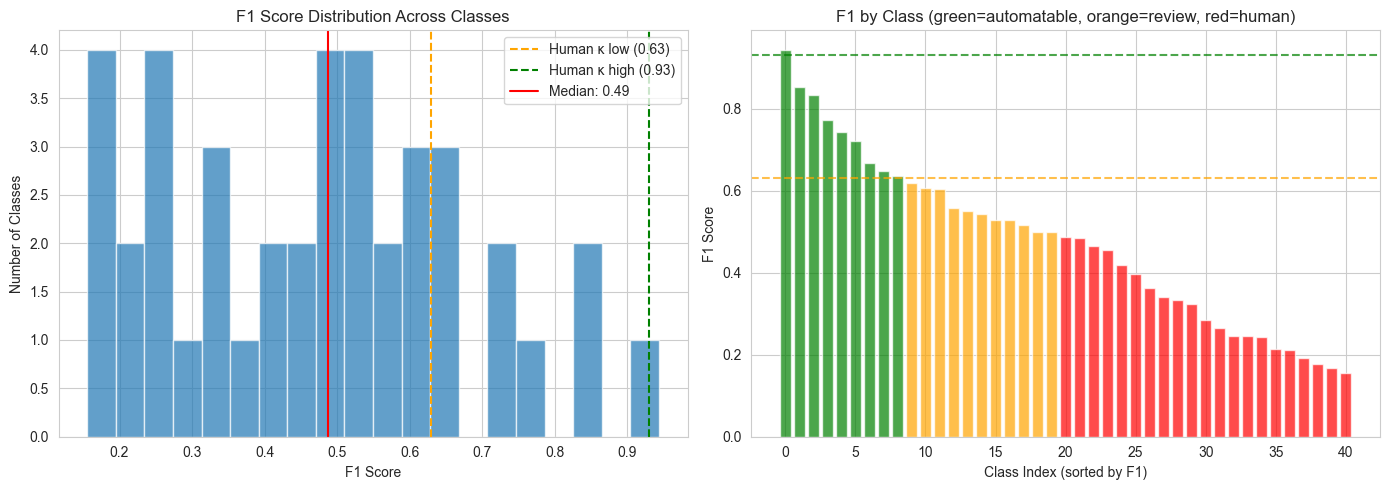

In [16]:
# F1 distribution histogram
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1 = axes[0]
ax1.hist(per_class['f1'], bins=20, edgecolor='white', alpha=0.7)
ax1.axvline(x=0.63, color='orange', linestyle='--', label='Human κ low (0.63)')
ax1.axvline(x=0.93, color='green', linestyle='--', label='Human κ high (0.93)')
median_f1 = float(per_class['f1'].median())
ax1.axvline(x=median_f1, color='red', linestyle='-', label=f'Median: {median_f1:.2f}')
ax1.set_xlabel('F1 Score')
ax1.set_ylabel('Number of Classes')
ax1.set_title('F1 Score Distribution Across Classes')
ax1.legend()

# Bar chart by class
ax2 = axes[1]
colors = ['green' if f1 >= 0.63 else 'orange' if f1 >= 0.5 else 'red' for f1 in per_class['f1']]
ax2.bar(range(len(per_class)), per_class['f1'], color=colors, alpha=0.7)
ax2.axhline(y=0.63, color='orange', linestyle='--', alpha=0.7)
ax2.axhline(y=0.93, color='green', linestyle='--', alpha=0.7)
ax2.set_xlabel('Class Index (sorted by F1)')
ax2.set_ylabel('F1 Score')
ax2.set_title('F1 by Class (green=automatable, orange=review, red=human)')

plt.tight_layout()
plt.show()

## 8. Threshold Analysis

In [17]:
# Try different global thresholds on VALIDATION set
from sklearn.metrics import f1_score, precision_score, recall_score

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
thresh_results = []

for thresh in thresholds:
    y_pred_t = (y_proba_val >= thresh).astype(int)
    thresh_results.append({
        'threshold': thresh,
        'f1_micro': f1_score(data.y_val, y_pred_t, average='micro', zero_division=0),
        'f1_macro': f1_score(data.y_val, y_pred_t, average='macro', zero_division=0),
        'precision': precision_score(data.y_val, y_pred_t, average='micro', zero_division=0),
        'recall': recall_score(data.y_val, y_pred_t, average='micro', zero_division=0),
        'avg_preds': y_pred_t.sum(axis=1).mean(),
    })

thresh_df = pd.DataFrame(thresh_results)
print("Global threshold analysis (on VALIDATION set):")
thresh_df

Global threshold analysis (on VALIDATION set):


,threshold,f1_micro,f1_macro,precision,recall,avg_preds
0,0.1,0.136178,0.082578,0.073075,0.997968,21.429653
1,0.2,0.282103,0.154663,0.164590,0.986284,9.402949
2,0.3,0.424108,0.258530,0.271201,0.972314,5.625747
3,0.4,0.543604,0.366862,0.379728,0.956312,3.951774
4,0.5,0.637174,0.457896,0.483320,0.934722,3.034675
5,0.6,0.701124,0.528318,0.586366,0.871730,2.332802
6,0.7,0.699122,0.546619,0.663624,0.738633,1.746513
7,0.8,0.592988,0.496258,0.741517,0.494031,1.045436


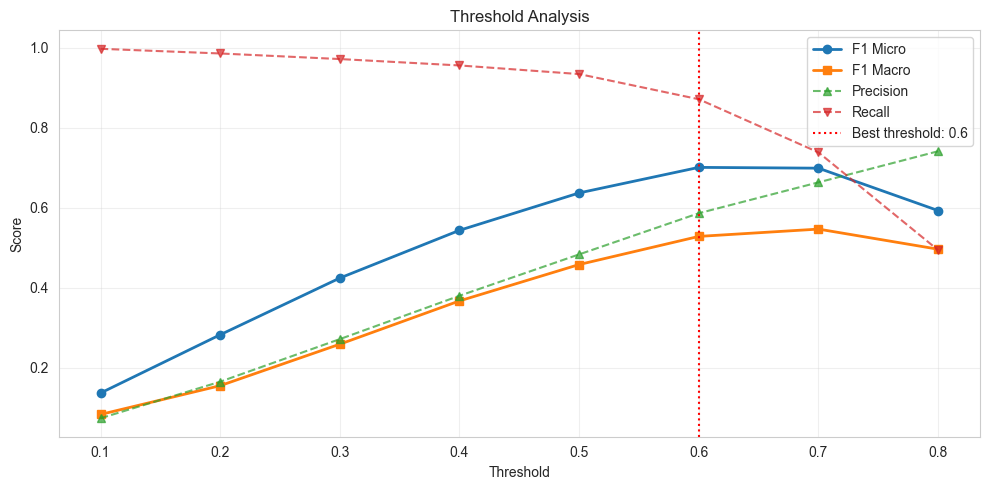


Best threshold: 0.6 → F1 Micro: 0.7011


In [18]:
# Plot threshold analysis
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(thresh_df['threshold'], thresh_df['f1_micro'], 'o-', label='F1 Micro', linewidth=2)
ax.plot(thresh_df['threshold'], thresh_df['f1_macro'], 's-', label='F1 Macro', linewidth=2)
ax.plot(thresh_df['threshold'], thresh_df['precision'], '^--', label='Precision', alpha=0.7)
ax.plot(thresh_df['threshold'], thresh_df['recall'], 'v--', label='Recall', alpha=0.7)

best_thresh = thresh_df.loc[thresh_df['f1_micro'].idxmax(), 'threshold']
ax.axvline(x=float(best_thresh), color='red', linestyle=':', label=f'Best threshold: {best_thresh}') # type: ignore

ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title('Threshold Analysis')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nBest threshold: {best_thresh} → F1 Micro: {thresh_df.loc[thresh_df['f1_micro'].idxmax(), 'f1_micro']:.4f}")

In [19]:
# Evaluate with optimal threshold (0.6)
OPTIMAL_THRESHOLD = 0.6

y_pred_optimal = (y_proba_test >= OPTIMAL_THRESHOLD).astype(int)
results_optimal = evaluator.evaluate(data.y_test, y_pred_optimal)

print(f"=== Results with Optimal Threshold ({OPTIMAL_THRESHOLD}) ===")
print(results_optimal.summary())

print(f"\nImprovement over default (0.5):")
print(f"  F1 Micro: {results.f1_micro:.4f} → {results_optimal.f1_micro:.4f} ({(results_optimal.f1_micro - results.f1_micro)*100:+.1f}%)")
print(f"  F1 Macro: {results.f1_macro:.4f} → {results_optimal.f1_macro:.4f} ({(results_optimal.f1_macro - results.f1_macro)*100:+.1f}%)")

=== Results with Optimal Threshold (0.6) ===
MULTI-LABEL EVALUATION RESULTS

Overall Metrics:
  F1 Micro:          0.7018
  F1 Macro:          0.5420
  F1 Weighted:       0.7577
  F1 Samples:        0.7303

  Precision (micro): 0.5853
  Precision (macro): 0.4654
  Recall (micro):    0.8764
  Recall (macro):    0.7429

  Hamming Loss:      0.0283
  Exact Match Ratio: 0.3675

Improvement over default (0.5):
  F1 Micro: 0.6333 → 0.7018 (+6.9%)
  F1 Macro: 0.4718 → 0.5420 (+7.0%)


In [20]:
# Per-class performance with optimal threshold
per_class_optimal = results_optimal.per_class_metrics

print(f"TOP 10 CLASSES (threshold={OPTIMAL_THRESHOLD}):")
display(per_class_optimal.nlargest(10, 'f1')[['label', 'precision', 'recall', 'f1', 'support']])

print(f"\nBOTTOM 10 CLASSES (threshold={OPTIMAL_THRESHOLD}):")
display(per_class_optimal.nsmallest(10, 'f1')[['label', 'precision', 'recall', 'f1', 'support']])

TOP 10 CLASSES (threshold=0.6):


,label,precision,recall,f1,support
1,Appellate Review,0.926761,0.964809,0.945402,682
0,On Appeal,0.850035,0.879623,0.864576,1379
2,Review of Administrative Decision,0.793878,0.930622,0.856828,418
24,Juvenile Delinquency Proceeding,0.812500,0.812500,0.812500,16
40,Certified Question,1.000000,0.666667,0.800000,6
30,Application to Vacate Arbitration Award,0.666667,0.909091,0.769231,11
28,Motion to Disqualify Counsel,0.818182,0.692308,0.750000,13
33,Motion for Extension of Time,0.600000,0.900000,0.720000,10
34,Motion for Relief from Order or Judgment,0.615385,0.800000,0.695652,10
11,Motion to Compel Arbitration,0.566667,0.894737,0.693878,38



BOTTOM 10 CLASSES (threshold=0.6):


,label,precision,recall,f1,support
23,Motion for Permanent Injunction,0.096386,0.444444,0.158416,18
16,Motion for Costs,0.126437,0.458333,0.198198,24
39,Petition for Custody,0.200000,0.250000,0.222222,8
17,Motion to Dismiss for Lack of Jurisdiction,0.141304,0.619048,0.230088,21
35,Motion to Stay Proceedings,0.173913,0.444444,0.250000,9
25,Motion to Set Aside or Vacate,0.200000,0.400000,0.266667,15
10,Motion to Dismiss for Lack of Subject Matter J...,0.156780,0.925000,0.268116,40
32,Motion to Strike All or Part of a Pleading,0.300000,0.300000,0.300000,10
37,Motion for Restraining or Protection Order,0.200000,0.625000,0.303030,8
7,Post-Trial Hearing Motion,0.190476,0.888889,0.313725,72


## 9. Prediction Distribution Analysis

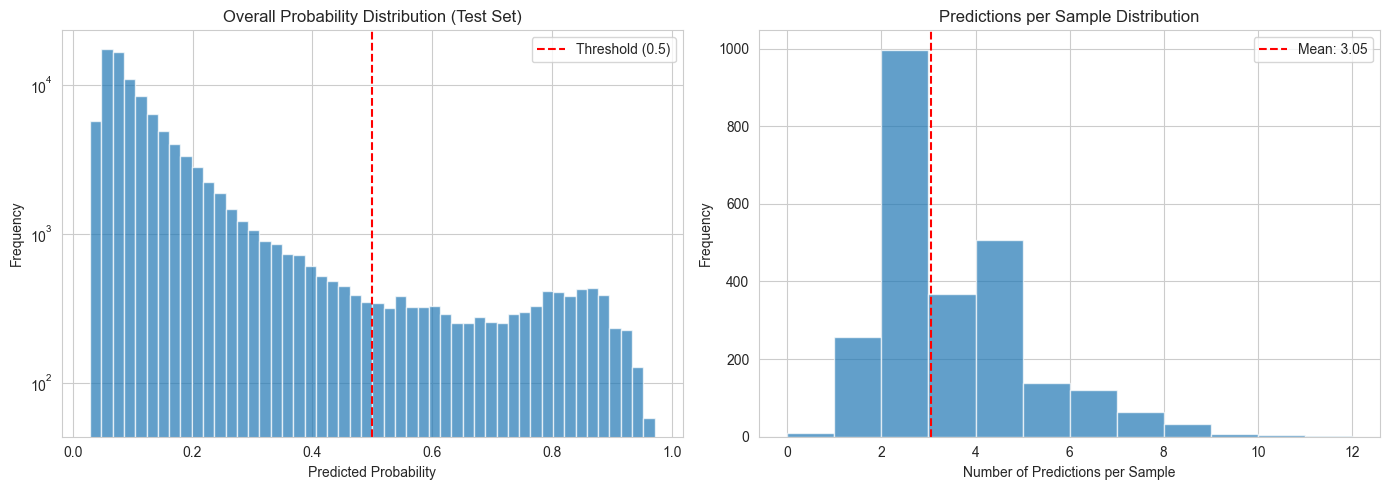

Samples with 0 predictions: 9 (0.4%)


In [21]:
# Analyze probability distribution (TEST set)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall probability distribution
ax1 = axes[0]
ax1.hist(y_proba_test.flatten(), bins=50, edgecolor='white', alpha=0.7)
ax1.axvline(x=0.5, color='red', linestyle='--', label='Threshold (0.5)')
ax1.set_xlabel('Predicted Probability')
ax1.set_ylabel('Frequency')
ax1.set_title('Overall Probability Distribution (Test Set)')
ax1.legend()
ax1.set_yscale('log')

# Predictions per sample
ax2 = axes[1]
preds_per_sample = y_pred_test.sum(axis=1)
max_preds = int(preds_per_sample.max())
mean_preds = float(preds_per_sample.mean())
ax2.hist(preds_per_sample, bins=range(0, max_preds + 2), edgecolor='white', alpha=0.7)
ax2.axvline(x=mean_preds, color='red', linestyle='--', label=f'Mean: {mean_preds:.2f}')
ax2.set_xlabel('Number of Predictions per Sample')
ax2.set_ylabel('Frequency')
ax2.set_title('Predictions per Sample Distribution')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"Samples with 0 predictions: {(preds_per_sample == 0).sum()} ({(preds_per_sample == 0).mean()*100:.1f}%)")

## 10. Feasibility Analysis

In [22]:
# Feasibility vs human annotator agreement
feasibility = results.get_feasibility_analysis(human_kappa_low=0.63, human_kappa_high=0.93)

print("=== AUTOMATION FEASIBILITY ===")
print(f"Fully automatable (F1 ≥ 0.63):  {feasibility['automation_feasible'].sum()} / {len(feasibility)}")
print(f"High confidence (F1 ≥ 0.93):    {feasibility['high_confidence'].sum()} / {len(feasibility)}")
print(f"Needs review (0.50 ≤ F1 < 0.63): {feasibility['needs_review'].sum()} / {len(feasibility)}")
print(f"Not feasible (F1 < 0.50):       {(~feasibility['automation_feasible'] & ~feasibility['needs_review']).sum()} / {len(feasibility)}")

=== AUTOMATION FEASIBILITY ===
Fully automatable (F1 ≥ 0.63):  9 / 41
High confidence (F1 ≥ 0.93):    1 / 41
Needs review (0.50 ≤ F1 < 0.63): 9 / 41
Not feasible (F1 < 0.50):       23 / 41


In [23]:
# Show automatable classes
print("\nCLASSES FEASIBLE FOR AUTOMATION:")
feasibility[feasibility['automation_feasible']][['label', 'f1', 'support']].sort_values('f1', ascending=False)


CLASSES FEASIBLE FOR AUTOMATION:


,label,f1,support
1,Appellate Review,0.943692,682
0,On Appeal,0.853205,1379
40,Certified Question,0.833333,6
2,Review of Administrative Decision,0.773333,418
24,Juvenile Delinquency Proceeding,0.742857,16
28,Motion to Disqualify Counsel,0.720000,13
11,Motion to Compel Arbitration,0.666667,38
6,Motion for Attorney's Fees,0.649057,93
14,Petition to Terminate Parental Rights,0.634615,33


## 10. Per-Class Threshold Optimization

Find the optimal threshold for each class independently to maximize F1.

In [24]:
# Find optimal threshold for each class using VALIDATION set
# Thresholds will be applied to TEST set for unbiased final evaluation
from sklearn.metrics import f1_score

thresholds_to_try = np.arange(0.1, 0.95, 0.05)
optimal_thresholds = []

for class_idx in range(len(data.label_names)):
    best_f1 = 0
    best_thresh = 0.5
    
    # Use VALIDATION set for optimization
    y_true_class = data.y_val[:, class_idx]
    y_proba_class = y_proba_val[:, class_idx]
    
    # Calculate F1 at default threshold (0.5)
    y_pred_at_05 = (y_proba_class >= 0.5).astype(int)
    if y_pred_at_05.sum() > 0 and y_pred_at_05.sum() < len(y_pred_at_05):
        f1_at_05 = f1_score(y_true_class, y_pred_at_05, zero_division=0)
    else:
        f1_at_05 = 0
    
    for t in thresholds_to_try:
        y_pred_class = (y_proba_class >= t).astype(int)
        # Handle case where all predictions are 0 or all are 1
        if y_pred_class.sum() == 0 or y_pred_class.sum() == len(y_pred_class):
            continue
        f1 = f1_score(y_true_class, y_pred_class, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t
    
    optimal_thresholds.append({
        'class_idx': class_idx,
        'label': data.label_names[class_idx],
        'optimal_threshold': best_thresh,
        'f1_at_0.5': f1_at_05,
        'f1_at_optimal': best_f1,
        'improvement': best_f1 - f1_at_05,
        'support': int(y_true_class.sum())
    })

threshold_df = pd.DataFrame(optimal_thresholds)
print(f"Per-class threshold optimization (on VALIDATION set):")
print(f"  Threshold range: {threshold_df['optimal_threshold'].min():.2f} - {threshold_df['optimal_threshold'].max():.2f}")
print(f"  Mean threshold:  {threshold_df['optimal_threshold'].mean():.2f}")

Per-class threshold optimization (on VALIDATION set):
  Threshold range: 0.45 - 0.90
  Mean threshold:  0.72


In [25]:
# Show classes with biggest improvements
print("TOP 10 CLASSES BY IMPROVEMENT:")
display(threshold_df.nlargest(10, 'improvement')[
    ['label', 'optimal_threshold', 'f1_at_0.5', 'f1_at_optimal', 'improvement', 'support']
])

# Threshold distribution
print(f"\nThreshold distribution:")
print(threshold_df['optimal_threshold'].describe())

TOP 10 CLASSES BY IMPROVEMENT:


,label,optimal_threshold,f1_at_0.5,f1_at_optimal,improvement,support
1,Application to Vacate Arbitration Award,0.85,0.416667,0.909091,0.492424,5
32,Motion to Transfer or Change Venue,0.80,0.409639,0.829268,0.419630,23
28,Motion to Renew,0.80,0.400000,0.761905,0.361905,9
24,Motion to Dismiss for Lack of Standing,0.80,0.266667,0.622222,0.355556,20
23,Motion to Dismiss for Lack of Personal Jurisdi...,0.90,0.428571,0.779661,0.351090,32
13,Motion for Preliminary Injunction,0.90,0.422907,0.728972,0.306064,52
15,Motion for Reconsideration,0.80,0.141414,0.439024,0.297610,22
18,Motion for Sanctions (Discovery),0.65,0.500000,0.750000,0.250000,5
25,Motion to Dismiss for Lack of Subject Matter J...,0.80,0.236504,0.471338,0.234834,50
14,Motion for Protective Order,0.85,0.478873,0.700000,0.221127,18



Threshold distribution:
count    41.000000
mean      0.724390
std       0.120479
min       0.450000
25%       0.650000
50%       0.750000
75%       0.800000
max       0.900000
Name: optimal_threshold, dtype: float64


In [26]:
# Apply per-class thresholds (from VAL) to TEST set for final unbiased evaluation
per_class_thresholds = threshold_df['optimal_threshold'].values

# Apply to TEST predictions
y_pred_test_perclass = np.zeros_like(y_proba_test, dtype=int)
for class_idx in range(len(data.label_names)):
    y_pred_test_perclass[:, class_idx] = (y_proba_test[:, class_idx] >= per_class_thresholds[class_idx]).astype(int)

# Also apply global optimal threshold (0.6) to TEST
OPTIMAL_THRESHOLD = 0.6
y_pred_test_optimal = (y_proba_test >= OPTIMAL_THRESHOLD).astype(int)

# Evaluate all configurations on TEST set
results_test_05 = evaluator.evaluate(data.y_test, y_pred_test)
results_test_06 = evaluator.evaluate(data.y_test, y_pred_test_optimal)
results_test_perclass = evaluator.evaluate(data.y_test, y_pred_test_perclass)

# Load TF-IDF predictions and compute metrics dynamically (instead of hardcoding)
tfidf_pred_path = Path('../outputs/tfidf_test_predictions.npz')
if tfidf_pred_path.exists():
    tfidf_data = np.load(tfidf_pred_path)
    y_pred_tfidf = tfidf_data['y_pred']
    results_tfidf = evaluator.evaluate(data.y_test, y_pred_tfidf)
    TFIDF_F1_MICRO = results_tfidf.f1_micro
    TFIDF_F1_MACRO = results_tfidf.f1_macro
    TFIDF_PRECISION = results_tfidf.precision_micro
    TFIDF_RECALL = results_tfidf.recall_micro
else:
    raise FileNotFoundError(f"Run NB 02 first to generate {tfidf_pred_path}")

print("=" * 80)
print("FINAL EVALUATION ON TEST SET (thresholds optimized on validation)")
print("=" * 80)
print(f"{'Metric':<15} {'TF-IDF':<12} {'LF (0.5)':<12} {'LF (0.6)':<12} {'LF Per-Class':<12}")
print("-" * 80)
print(f"{'F1 Micro':<15} {TFIDF_F1_MICRO:<12.4f} {results_test_05.f1_micro:<12.4f} {results_test_06.f1_micro:<12.4f} {results_test_perclass.f1_micro:<12.4f}")
print(f"{'F1 Macro':<15} {TFIDF_F1_MACRO:<12.4f} {results_test_05.f1_macro:<12.4f} {results_test_06.f1_macro:<12.4f} {results_test_perclass.f1_macro:<12.4f}")
print(f"{'Precision':<15} {TFIDF_PRECISION:<12.4f} {results_test_05.precision_micro:<12.4f} {results_test_06.precision_micro:<12.4f} {results_test_perclass.precision_micro:<12.4f}")
print(f"{'Recall':<15} {TFIDF_RECALL:<12.4f} {results_test_05.recall_micro:<12.4f} {results_test_06.recall_micro:<12.4f} {results_test_perclass.recall_micro:<12.4f}")
print("=" * 80)
print(f"\nGap to TF-IDF (F1 Micro): {(results_test_perclass.f1_micro - TFIDF_F1_MICRO)*100:+.1f}%")
print(f"Gap to TF-IDF (F1 Macro): {(results_test_perclass.f1_macro - TFIDF_F1_MACRO)*100:+.1f}%")

FINAL EVALUATION ON TEST SET (thresholds optimized on validation)
Metric          TF-IDF       LF (0.5)     LF (0.6)     LF Per-Class
--------------------------------------------------------------------------------
F1 Micro        0.7524       0.6333       0.7018       0.7735      
F1 Macro        0.5330       0.4718       0.5420       0.6000      
Precision       0.6482       0.4785       0.5853       0.7116      
Recall          0.8966       0.9363       0.8764       0.8472      

Gap to TF-IDF (F1 Micro): +2.1%
Gap to TF-IDF (F1 Macro): +6.7%


## 11. Summary

In [27]:
print("=" * 60)
print("MODEL EVALUATION SUMMARY")
print("=" * 60)
if history:
    print(f"\nModel: Legal-Longformer (epoch {history['best_epoch']})")
    print(f"Validation F1 Micro: {history['best_f1']:.4f}")
    print(f"Validation F1 Macro: {history['val_f1_macro'][history['best_epoch']-1]:.4f}")

print(f"\nTest Set Performance (threshold=0.5):")
print(f"  F1 Micro:      {results.f1_micro:.4f}")
print(f"  F1 Macro:      {results.f1_macro:.4f}")
print(f"  F1 Weighted:   {results.f1_weighted:.4f}")
print(f"  Precision:     {results.precision_micro:.4f}")
print(f"  Recall:        {results.recall_micro:.4f}")

print(f"\nOptimal Threshold Analysis:")
best_idx = thresh_df['f1_micro'].idxmax()
print(f"  Best threshold:  {thresh_df.loc[best_idx, 'threshold']}")
print(f"  F1 Micro:        {thresh_df.loc[best_idx, 'f1_micro']:.4f}")

print(f"\nAutomation Feasibility (vs human κ=0.63-0.93):")
print(f"  High confidence (F1≥0.93): {feasibility['high_confidence'].sum()} / {len(feasibility)} classes")
print(f"  Automatable (F1≥0.63):     {feasibility['automation_feasible'].sum()} / {len(feasibility)} classes")
print("=" * 60)

MODEL EVALUATION SUMMARY

Model: Legal-Longformer (epoch 4)
Validation F1 Micro: 0.6277
Validation F1 Macro: 0.4168

Test Set Performance (threshold=0.5):
  F1 Micro:      0.6333
  F1 Macro:      0.4718
  F1 Weighted:   0.7193
  Precision:     0.4785
  Recall:        0.9363

Optimal Threshold Analysis:
  Best threshold:  0.6
  F1 Micro:        0.7011

Automation Feasibility (vs human κ=0.63-0.93):
  High confidence (F1≥0.93): 1 / 41 classes
  Automatable (F1≥0.63):     9 / 41 classes


In [28]:
# Save Legal-Longformer predictions for ensemble analysis
from src.model_evaluator import save_predictions

pred_path = Path('../outputs/longformer_predictions.npz')
save_predictions(y_pred_test, y_proba_test, str(pred_path))
print(f"Saved Legal-Longformer predictions to {pred_path}")

Saved Legal-Longformer predictions to ../outputs/longformer_predictions.npz
